In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Datasets/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Datasets


In [ ]:
import numpy as np
import tensorflow as tf

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

import os
import cv2
import random

from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print(100*"#")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Oct  5 09:19:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

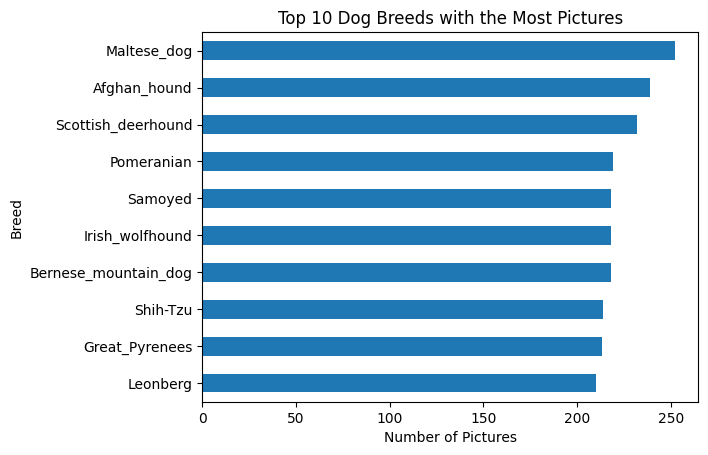

In [ ]:
path = "Images"
categories = os.listdir(path)

a = pd.DataFrame([[s[10:],len(os.listdir(path+"/"+s))] for s in categories], columns=['Breed','pic_number'])
top_10_breeds = a.sort_values(by='pic_number', ascending=False).head(10)
top_10_breeds.plot(kind='barh', x='Breed', y='pic_number', legend=False)
plt.xlabel('Number of Pictures')
plt.ylabel('Breed')
plt.title('Top 10 Dog Breeds with the Most Pictures')
plt.gca().invert_yaxis()  # Reverse the order to have the highest count at the top
plt.show()

In [ ]:
def load_images_and_labels(categories, n_img=210):
    img_lst=[]
    labels=[]
    for category in tqdm(categories):
        folder = os.listdir(path+"/"+category)
        random.seed(20)                        # shuffle because they are organized as coming from list_dir function
        folder = random.choices(folder, k=n_img) # here limites the number of images per categories
        for image_name in folder:
            img = cv2.imread(path+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     # keeps RGB columns
            img = cv2.resize(img,(224, 224), interpolation=cv2.INTER_AREA)  # resize image to 224 x 224 because the input image resolution for AlexNet is 227 x 227
            img_array = Image.fromarray(img, 'RGB')        #.  'RGB' / 'L'   for color or grey scale
            img_lst.append(np.array(img_array))
            labels.append(category[10:])
    print("images loaded")
    return img_lst, labels



In [ ]:
def apply_transfo(images, labels, n_transfo=3, keep_original=False):
    img_lst=[]
    _labels = []
    print("expected iterations: ", len(images))
    for idx, image in tqdm(enumerate(images)):
        if keep_original:
            img_lst.append(image)
            _labels.append(labels[idx])
        for i in range(n_transfo):             # apply n random transformations
            augmented_img = datagen.random_transform(image)
            img_lst.append(np.array(augmented_img))
            _labels.append(labels[idx])
    print("images transformed")
    return img_lst, _labels

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,      # Random rotation (up to 20 degrees)
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2, # Random vertical shift
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest',     # Fill mode for newly created pixels
    data_format='channels_last'
)


In [ ]:
def normalize_(images,labels):
  images = np.array(images)
  labels = np.array(labels)
  #print("\n==> Necessary to normalize images' pixels")
  images = images.astype(np.float32)                      #### not necessary if using image transfo function ?!?
  images = images/255
  #print("\n\n*** images format after normalisation ***\n\n",images[1][:2])
  print("\nShapes:\nImages shape ",images.shape,"Labels shape = ",labels.shape)
  return (images,labels)


In [ ]:

path = "Images"
categories = os.listdir(path)

img_lst, labels = load_images_and_labels(categories, n_img=210)
images, labels = apply_transfo(img_lst, labels, n_transfo = 3, keep_original=False)
images, labels = normalize_(images,labels)

100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


images loaded
expected iterations:  2100


2100it [00:54, 38.69it/s]


images transformed

Shapes:
Images shape  (6300, 224, 224, 3) Labels shape =  (6300,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
enc_label = label_enc.fit_transform(labels)

# split to learn model
x_train, x_test, y_train, y_test = train_test_split(images, enc_label, train_size = 0.8, random_state = 42, stratify=labels)

x_train = x_train.astype('float32')
y_train = y_train.astype('int32')
x_test = x_test.astype('float32')
y_test = y_test.astype('int32')



In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras import Model, regularizers
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
def model_builder(hp):
    _model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    # Définir les paramètres à optimiser
    #hp_units1 = hp.Int('units1', min_value=256, max_value=512, step=256)
    #hp_units2 = hp.Int('units2', min_value=256, max_value=512, step=256)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])#, 1e-5])
    #hp_dropout_1 = hp.Choice('dropout1', values=[0.0, 1e-1])#, 2e-1])
    #hp_dropout_2 = hp.Choice('dropout2', values=[0.0, 1e-1])#, 2e-1])
    #hp_dense1_l1 = hp.Choice('dense1_l1', values=[1e-3,1e-4])#,1e-5])
    #hp_dense1_l2 = hp.Choice('dense1_l2', values=[1e-3,1e-4,1e-5])
    #hp_dense2_l1 = hp.Choice('dense2_l1', values=[1e-3,1e-4])#,1e-5])
    #hp_dense2_l2 = hp.Choice('dense2_l2', values=[1e-3,1e-4,1e-5])
    # Récupérer la sortie de ce réseau
    x = _model.output
    x = Flatten(name="flatten")(x)
    x = Dense(units=512, activation='relu',
              kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-3))(x)
    x = Dropout(0)(x)
    x = Dense(units=512, activation='relu',
              kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3))(x)
    x = Dropout(0.1)(x)
    # Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
    x = Dense(10, activation='softmax')(x)
    # Définir le nouveau modèle
    _model = Model(inputs=_model.input, outputs=x)

    for layer in _model.layers[0:-5]:
        layer.trainable = False

    _model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return _model

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt
import keras
from tensorflow.keras.layers import Dropout

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='tuning_dogs',
                     project_name='first_trial',
                     overwrite = True)                                            # to remove if want to keep saved searches

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=3)

tuner.search(x_train, y_train, epochs=5,
             validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer 1 and 2 are {best_hps.get('units1'),best_hps.get('units2')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the best dropout ratio for each dense layer is {best_hps.get('dropout1'),best_hps.get('dropout2')}
and the best regularisation are {best_hps.get('dense1_l1'),best_hps.get('dense1_l2')} for layer 1 and {best_hps.get('dense2_l1'),best_hps.get('dense2_l2')} for layer 2.
""")

Trial 2 Complete [00h 00m 54s]
val_accuracy: 0.6240079402923584

Best val_accuracy So Far: 0.6240079402923584
Total elapsed time: 00h 01m 52s


KeyError: ignored

In [ ]:
import keras
from keras.callbacks import EarlyStopping

stop_early = EarlyStopping(monitor='val_loss', patience=3)
model = tuner.hypermodel.build(best_hps)#(x)
model_info = model.fit(x_train, y_train, batch_size=64, epochs=15, validation_split=0.3, callbacks=[stop_early])


Epoch 1/15
56/56 [==============================] - 42s 562ms/step - loss: 21.0988 - accuracy: 0.2948 - val_loss: 18.6262 - val_accuracy: 0.3724
Epoch 2/15
56/56 [==============================] - 22s 390ms/step - loss: 16.5631 - accuracy: 0.5734 - val_loss: 15.0867 - val_accuracy: 0.4914
Epoch 3/15
56/56 [==============================] - 22s 387ms/step - loss: 13.5001 - accuracy: 0.7389 - val_loss: 12.8193 - val_accuracy: 0.5906
Epoch 4/15
56/56 [==============================] - 22s 389ms/step - loss: 11.5880 - accuracy: 0.8056 - val_loss: 11.3713 - val_accuracy: 0.5959
Epoch 5/15
56/56 [==============================] - 22s 391ms/step - loss: 10.1473 - accuracy: 0.8801 - val_loss: 10.1645 - val_accuracy: 0.6065
Epoch 6/15
56/56 [==============================] - 22s 392ms/step - loss: 8.9807 - accuracy: 0.9260 - val_loss: 9.1213 - val_accuracy: 0.6402
Epoch 7/15
56/56 [==============================] - 22s 391ms/step - loss: 8.0387 - accuracy: 0.9348 - val_loss: 8.2749 - val_accura

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
c = confusion_matrix(y_test,np.argmax(pred, axis=1))

# **************************************************

fig, ax = plt.subplots(figsize=(3.5, 3))
sns.heatmap(c, ax=ax, yticklabels=label_enc.inverse_transform(np.arange(10)), annot=True, fmt='.0f', cbar=False)
#ax.set_xticklabels(labels_, rotation=45, ha='right')
plt.show()

# **************************************************

from sklearn.metrics import classification_report
print(classification_report(y_test,np.argmax(pred, axis=1)))

# **************************************************

plt.figure(figsize=(4,4))
plt.plot(model_info.history['loss'], color='blue', label='Loss')
plt.plot(model_info.history['val_loss'], color='cyan', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right', bbox_to_anchor=(1,0.8))

ax2 = plt.twinx()
plt.plot(model_info.history['accuracy'], color='red', label='Accuracy')
plt.plot(model_info.history['val_accuracy'], color='pink', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='center right')
plt.show()

NameError: ignored

In [ ]:
import pickle


!mkdir -p saved_models/vgg16
#pickle.dump(labels, open('breed_names.save', 'wb'))
model.save('saved_models/vgg16/model_vgg16_final.keras', overwrite=True, save_format="keras")
#model.save_weights('model_vgg16_tuned_weight.keras',overwrite=True


# my_model directory
%ls saved_models

# Contains an assets folder, saved_model.pb, and variables folder.
%ls saved_models/vgg16


vgg16/
model_vgg16_final.keras


In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
# check that model is really saved

new_model = tf.keras.models.load_model('saved_models/vgg16/model_vgg16_final.keras')

# Check its architecture
new_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
ls saved_models/vgg16

model_vgg16_final.keras
